Разобраться с моделькой перевода как она устроена
запустить для перевода с русского на английский (при желании можно взять другие пары языков) два варианта с вниманием и без внимания
оценить качество насколько корректно переводит 

In [1]:
import unicodedata
import re
import numpy as np
import os
import io
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

2024-01-14 16:53:05.694422: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 16:53:05.694483: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 16:53:05.695620: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 16:53:05.781271: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path_to_file = r'/media/dmitriy/Disk/Downloads/ai_nlp_hw_data/hw_10/rus.txt'

## Подготовка данных

In [3]:
def preprocess_sentence(w):
    w = w.lower().strip()
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
    return zip(*word_pairs)

In [5]:
en, ru = create_dataset(path_to_file, None)

In [6]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

## Создание датасета

In [7]:
def load_dataset(path, num_examples=None):
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [8]:
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

In [9]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [10]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [11]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [12]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

2024-01-14 17:03:31.421622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1825 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:03:00.0, compute capability: 7.5


In [13]:
example_input_batch, example_target_batch = next(iter(dataset))

## Построение модели машинного перевода

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=False,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return state


    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [15]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_hidden = encoder(example_input_batch, sample_hidden)

2024-01-14 17:06:20.782864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902


In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)


    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state

In [17]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden)

In [18]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [19]:
checkpoint_dir = '/media/dmitriy/Disk/Downloads/ai_nlp_hw_data/hw_10/training_nmt_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [20]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden = decoder(dec_input, dec_hidden)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [21]:
EPOCHS = 50
for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

2024-01-14 17:10:28.922902: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f21d03a7db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-14 17:10:28.922931: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-01-14 17:10:28.940193: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-14 17:10:29.053073: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-14 17:10:29.199777: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1 Batch 0 Loss 4.6669
Epoch 1 Batch 100 Loss 2.0640
Epoch 1 Batch 200 Loss 1.7110
Epoch 1 Batch 300 Loss 1.6674
Epoch 1 Batch 400 Loss 1.5674
Epoch 1 Batch 500 Loss 1.5343
Epoch 1 Batch 600 Loss 1.3890
Epoch 1 Batch 700 Loss 1.3590
Epoch 1 Batch 800 Loss 1.3191
Epoch 1 Batch 900 Loss 1.2131
Epoch 1 Batch 1000 Loss 1.2629
Epoch 1 Batch 1100 Loss 1.1779
Epoch 1 Batch 1200 Loss 1.1758
Epoch 1 Loss 1.5077
Time taken for 1 epoch 121.37079119682312 sec

Epoch 2 Batch 0 Loss 1.0203
Epoch 2 Batch 100 Loss 1.0194
Epoch 2 Batch 200 Loss 0.9932
Epoch 2 Batch 300 Loss 0.9838
Epoch 2 Batch 400 Loss 0.9597
Epoch 2 Batch 500 Loss 0.9854
Epoch 2 Batch 600 Loss 0.8730
Epoch 2 Batch 700 Loss 0.8080
Epoch 2 Batch 800 Loss 0.7961
Epoch 2 Batch 900 Loss 0.8725
Epoch 2 Batch 1000 Loss 0.8283
Epoch 2 Batch 1100 Loss 0.8149
Epoch 2 Batch 1200 Loss 0.7760
Epoch 2 Loss 0.9093
Time taken for 1 epoch 100.99418663978577 sec

Epoch 3 Batch 0 Loss 0.5970
Epoch 3 Batch 100 Loss 0.6864
Epoch 3 Batch 200 Loss 0.6

In [22]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                             maxlen=max_length_inp,
                                                             padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden = decoder(dec_input, dec_hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence

In [23]:
def translate(sentence):
    result, sentence = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [25]:
translate('Хорошая погода')

Input: <start> хорошая погода <end>
Predicted translation: it's nice and have a good . <end> 


In [26]:
translate('Я иду в школу')

Input: <start> я иду в школу <end>
Predicted translation: i walk to school . <end> 


In [27]:
translate('Я иду на урок  в школу')

Input: <start> я иду на урок в школу <end>
Predicted translation: i go to school . <end> 


In [28]:
translate('Я сам решаю трудную задачу в школе')

Input: <start> я сам решаю трудную задачу в школе <end>
Predicted translation: i did my duty . <end> 


In [29]:
translate(u'Я не люблю, когда идет снег.')

Input: <start> я не люблю , когда идет снег . <end>
Predicted translation: i don't love my mother . <end> 


In [30]:
translate(u'Сегодня я пойду гулять, а потом пойду в магазин')

Input: <start> сегодня я пойду гулять , а потом пойду в магазин <end>
Predicted translation: i'll go if now . <end> 


In [31]:
translate('Мама приготовила вкусный обед для нашей большой семьи')

Input: <start> мама приготовила вкусный обед для нашей большой семьи <end>
Predicted translation: mom has many point now . <end> 


In [32]:
translate(u'Мне здесь нравится, но я очень скучаю по дому. Там остались мама и папа.')

Input: <start> мне здесь нравится , но я очень скучаю по дому . там остались мама и папа . <end>
Predicted translation: my dad really , am <end> 


## Построение модели машинного перевода с вниманием

In [33]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')


    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state


    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [34]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [35]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)


    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [36]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [37]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        # используем слой внимания
        self.attention = BahdanauAttention(self.dec_units)


    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [38]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7356)


In [42]:
optimizer = tf.keras.optimizers.legacy.Adam()
checkpoint_dir = '/media/dmitriy/Disk/Downloads/ai_nlp_hw_data/hw_10/training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [43]:
@tf.function
def train_step_att(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [44]:
EPOCHS = 50
for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step_att(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.5654
Epoch 1 Batch 100 Loss 2.1681
Epoch 1 Batch 200 Loss 1.7379
Epoch 1 Batch 300 Loss 1.7128
Epoch 1 Batch 400 Loss 1.7148
Epoch 1 Batch 500 Loss 1.6413
Epoch 1 Batch 600 Loss 1.4715
Epoch 1 Batch 700 Loss 1.3382
Epoch 1 Batch 800 Loss 1.2165
Epoch 1 Batch 900 Loss 1.1089
Epoch 1 Batch 1000 Loss 0.9853
Epoch 1 Batch 1100 Loss 1.0793
Epoch 1 Batch 1200 Loss 1.0342
Epoch 1 Loss 1.4579
Time taken for 1 epoch 194.12893772125244 sec

Epoch 2 Batch 0 Loss 0.7799
Epoch 2 Batch 100 Loss 0.8632
Epoch 2 Batch 200 Loss 0.7739
Epoch 2 Batch 300 Loss 0.7659
Epoch 2 Batch 400 Loss 0.6234
Epoch 2 Batch 500 Loss 0.5411
Epoch 2 Batch 600 Loss 0.5721
Epoch 2 Batch 700 Loss 0.5195
Epoch 2 Batch 800 Loss 0.5189
Epoch 2 Batch 900 Loss 0.6654
Epoch 2 Batch 1000 Loss 0.5505
Epoch 2 Batch 1100 Loss 0.5966
Epoch 2 Batch 1200 Loss 0.3997
Epoch 2 Loss 0.6036
Time taken for 1 epoch 181.85104823112488 sec

Epoch 3 Batch 0 Loss 0.3455
Epoch 3 Batch 100 Loss 0.3648
Epoch 3 Batch 200 Loss 0.3

In [47]:
def evaluate_att(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [48]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [49]:
def translate_att(sentence):
    result, sentence, attention_plot = evaluate_att(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [50]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> хорошая погода <end>
Predicted translation: it's good news . <end> 


/tmp/ipykernel_58459/1344664323.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_58459/1344664323.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


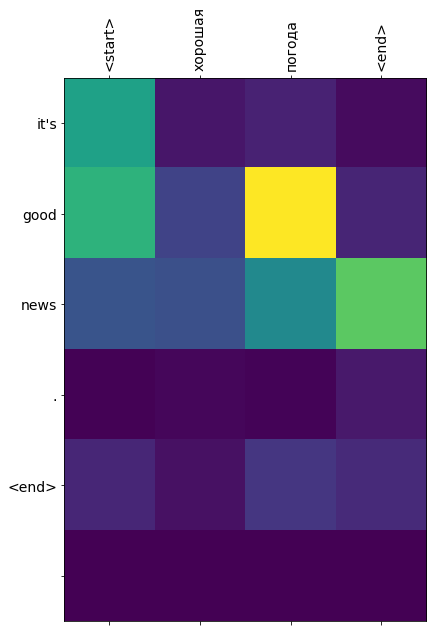

In [51]:
translate_att('Хорошая погода')

Input: <start> я иду в школу <end>
Predicted translation: i go to school . <end> 


/tmp/ipykernel_58459/1344664323.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_58459/1344664323.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


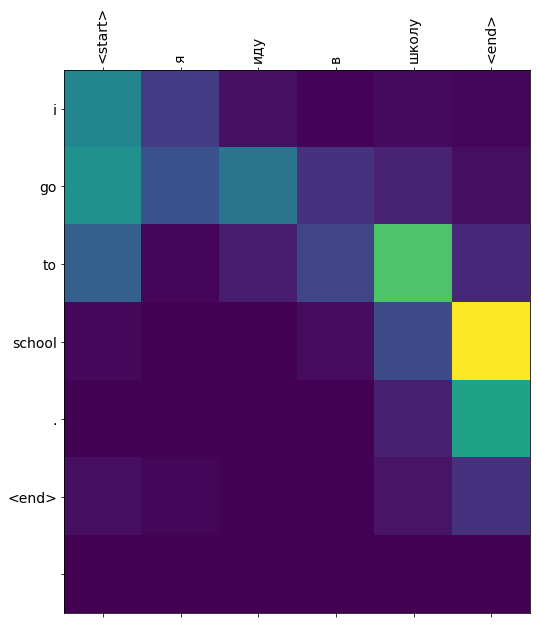

In [52]:
translate_att('Я иду в школу')

Input: <start> я иду на урок в школу <end>
Predicted translation: i go to go shopping . <end> 


/tmp/ipykernel_58459/1344664323.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_58459/1344664323.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


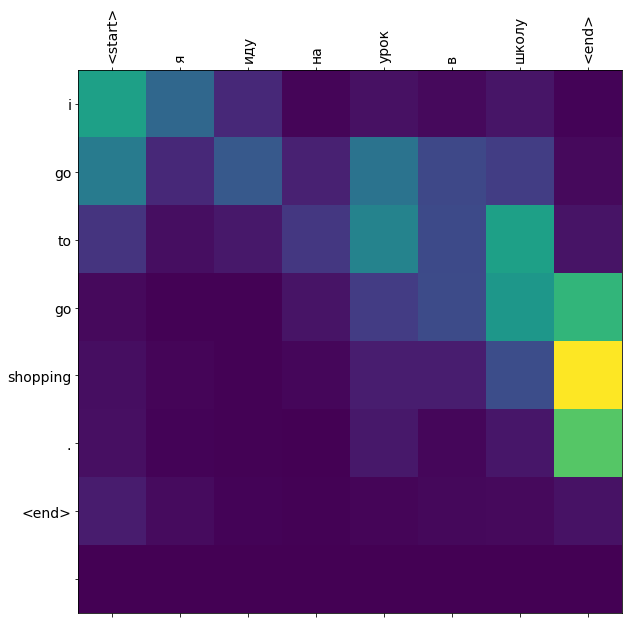

In [53]:
translate_att('Я иду на урок в школу')

Input: <start> я сам решаю трудную задачу в школе <end>
Predicted translation: i unplugged last wine . <end> 


/tmp/ipykernel_58459/1344664323.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_58459/1344664323.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


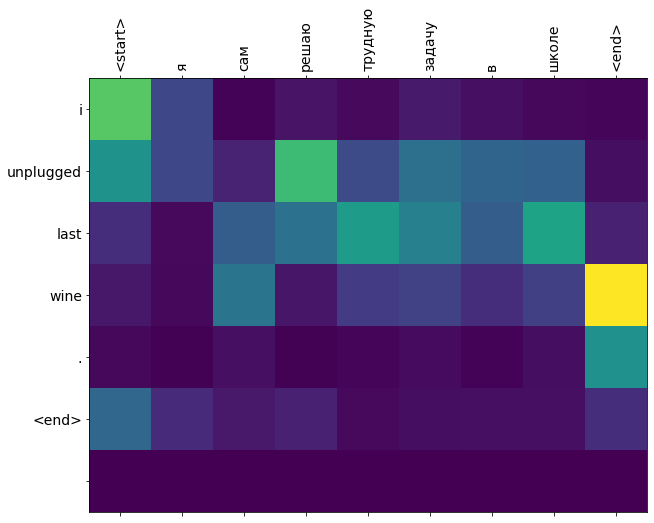

In [54]:
translate_att('Я сам решаю трудную задачу в школе')

Input: <start> я не люблю , когда идет снег . <end>
Predicted translation: i don't like when it works . <end> 


/tmp/ipykernel_58459/1344664323.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_58459/1344664323.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


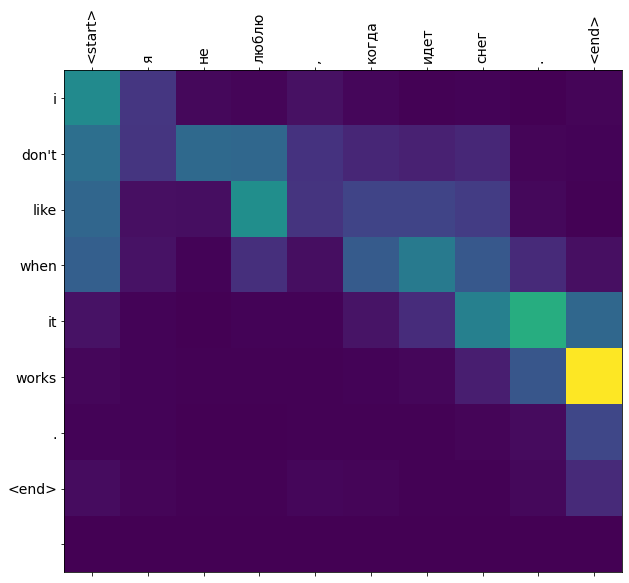

In [55]:
translate_att(u'Я не люблю, когда идет снег.')

Input: <start> сегодня я пойду гулять , а потом пойду в магазин <end>
Predicted translation: i'll go today . <end> 


/tmp/ipykernel_58459/1344664323.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_58459/1344664323.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


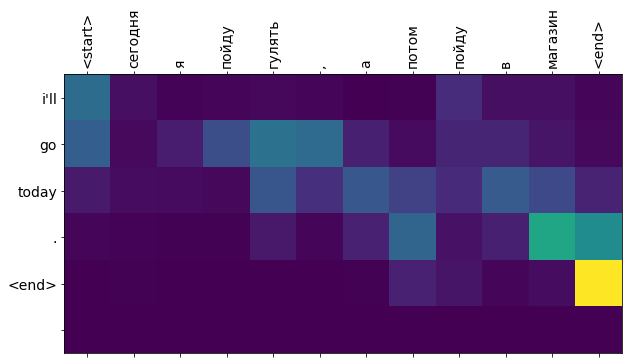

In [56]:
translate_att(u'Сегодня я пойду гулять, а потом пойду в магазин')

Input: <start> мама приготовила вкусный обед для нашей большой семьи <end>
Predicted translation: a too drinking a nice chained . <end> 


/tmp/ipykernel_58459/1344664323.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_58459/1344664323.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


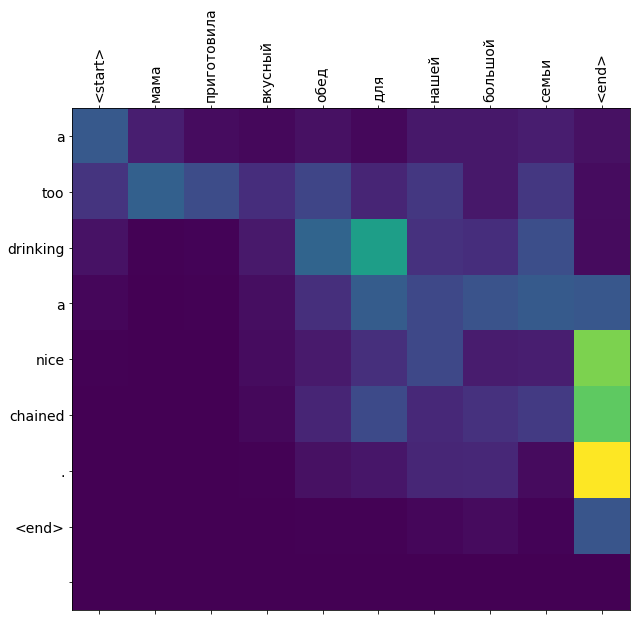

In [57]:
translate_att('Мама приготовила вкусный обед для нашей большой семьи')

Input: <start> мне здесь нравится , но я очень скучаю по дому . там остались мама и папа . <end>
Predicted translation: all but poor . <end> 


/tmp/ipykernel_58459/1344664323.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_58459/1344664323.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


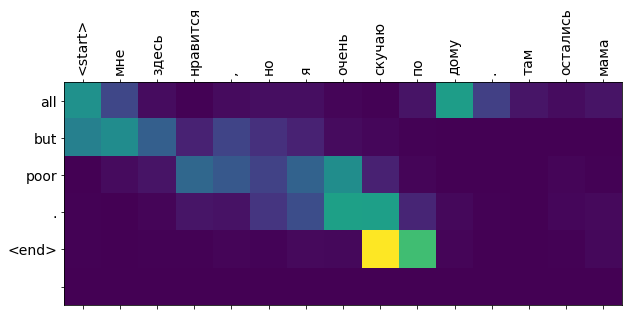

In [58]:
translate_att(u'Мне здесь нравится, но я очень скучаю по дому. Там остались мама и папа.')